# Autoregressive Model

In [ ]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

In this example we are going to perform an automated Variational Bayesian Inference for autoregressive model that can be represented as following:

$$\begin{aligned}
p(\gamma) &= \mathrm{Gamma}(\gamma|a, b),\\
p(\mathbf{\theta}) &= \mathcal{N}(\mathbf{\theta}|\mathbf{\mu}, \Sigma),\\
p(x_t|\mathbf{x}_{t-1:t-k}) &= \mathcal{N}(x_t|\mathbf{\theta}^{T}\mathbf{x}_{t-1:t-k}, \gamma^{-1}),\\
p(y_t|x_t) &= \mathcal{N}(y_t|x_t, \tau^{-1}),
\end{aligned}$$

where $x_t$ is a current state of our system, $\mathbf{x}_{t-1:t-k}$ is a sequence of $k$ previous states, $k$ is an order of autoregression process, $\mathbf{\theta}$ is a vector of transition coefficients, $\gamma$ is a precision of state transition process, $y_k$ is a noisy observation of $x_k$ with precision $\tau$.

For a more rigorous introduction to Bayesian inference in Autoregressive models we refer to [Albert Podusenko, Message Passing-Based Inference for Time-Varying Autoregressive Models](https://www.mdpi.com/1099-4300/23/6/683).

We start with importing all needed packages:

In [1]:
using RxInfer, Distributions, LinearAlgebra, Random, Plots, BenchmarkTools, Parameters

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1662


Let's generate some synthetic dataset, we use a predefined sets of coeffcients for $k$ = 1, 3 and 5 respectively:

In [2]:
# The following coefficients correspond to stable poles
coefs_ar_1 = [-0.27002517200218096]
coefs_ar_2 = [0.4511170798064709, -0.05740081602446657]
coefs_ar_5 = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

In [3]:
function generate_ar_data(rng, n, θ, γ, τ)
    order        = length(θ)
    states       = Vector{Vector{Float64}}(undef, n + 3order)
    observations = Vector{Float64}(undef, n + 3order)
    
    γ_std = sqrt(inv(γ))
    τ_std = sqrt(inv(τ))
    
    states[1] = randn(rng, order)
    
    for i in 2:(n + 3order)
        states[i]       = vcat(rand(rng, Normal(dot(θ, states[i - 1]), γ_std)), states[i-1][1:end-1])
        observations[i] = rand(rng, Normal(states[i][1], τ_std))
    end
    
    return states[1+3order:end], observations[1+3order:end]
end

generate_ar_data (generic function with 1 method)

In [4]:
# Seed for reproducibility
seed = 123
rng  = MersenneTwister(seed)

# Number of observations in synthetic dataset
n = 500

# AR process parameters
real_γ = 1.0
real_τ = 0.5
real_θ = coefs_ar_5

states, observations = generate_ar_data(rng, n, real_θ, real_γ, real_τ);

Let's plot our synthetic dataset:

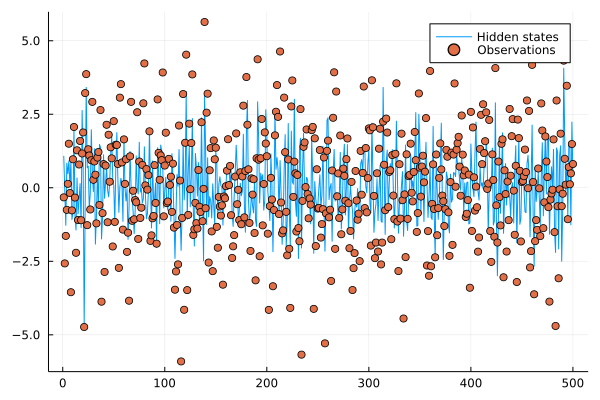

In [5]:
plot(first.(states), label = "Hidden states")
scatter!(observations, label = "Observations")

Next step is to specify probabilistic model, inference constraints and run inference procedure with `RxInfer`. We will specify two different models for Multivariate AR with order $k$ > 1 and for Univariate AR (reduces to simple State-Space-Model) with order $k$ = 1.

In [6]:
@model function lar_model(T::Type, n, order, c, τ)
    
     
    # We create a sequence of random variables for hidden states
    x = randomvar(n)
    # As well a sequence of observartions
    y = datavar(Float64, n)
    
    ct = constvar(c)
    # We assume observation noise to be known
    cτ = constvar(τ)
    
    γ  = randomvar()
    θ  = randomvar()
    x0 = randomvar()
    
    # Prior for first state
    if T === Multivariate
        γ  ~ Gamma(α = 1.0, β = 1.0)
        θ  ~ MvNormal(μ = zeros(order), Λ = diageye(order))
        x0 ~ MvNormal(μ = zeros(order), Λ = diageye(order))
    else
        γ  ~ Gamma(α = 1.0, β = 1.0)
        θ  ~ Normal(μ = 0.0, γ = 1.0)
        x0 ~ Normal(μ = 0.0, γ = 1.0)
    end
    
    x_prev = x0
    
    for i in 1:n
        
        x[i] ~ AR(x_prev, θ, γ) 
        
        if T === Multivariate
            y[i] ~ Normal(μ = dot(ct, x[i]), γ = cτ)
        else
            y[i] ~ Normal(μ = ct * x[i], γ = cτ)
        end
        
        x_prev = x[i]
    end

end

In [7]:
@constraints function ar_constraints() 
    q(x0, x, θ, γ) = q(x0, x)q(θ)q(γ)
end

ar_constraints (generic function with 1 method)

In [8]:
@meta function ar_meta(artype, order, stype)
    AR(x, θ, γ) -> ARMeta(artype, order, stype)
end

ar_meta (generic function with 1 method)

In [9]:
morder  = 5
martype = Multivariate
mc      = ReactiveMP.ar_unit(martype, morder)
mconstraints = ar_constraints()
mmeta        = ar_meta(martype, morder, ARsafe())

moptions = (limit_stack_depth = 100, )

mmodel         = lar_model(martype, length(observations), morder, mc, real_τ)
mdata          = (y = observations, )
minitmarginals = (γ = GammaShapeRate(1.0, 1.0), θ = MvNormalMeanPrecision(zeros(morder), diageye(morder)))
mreturnvars    = (x = KeepLast(), γ = KeepEach(), θ = KeepEach())

# First execution is slow due to Julia's initial compilation 
# Subsequent runs will be faster (benchmarks are below)
mresult = inference(
    model = mmodel, 
    data  = mdata,
    constraints   = mconstraints,
    meta          = mmeta,
    options       = moptions,
    initmarginals = minitmarginals,
    returnvars    = mreturnvars,
    free_energy   = true,
    iterations    = 25, 
    showprogress  = false
);

In [10]:
@unpack x, γ, θ = mresult.posteriors

fe = mresult.free_energy;

We will use different initial marginals depending on type of our AR process

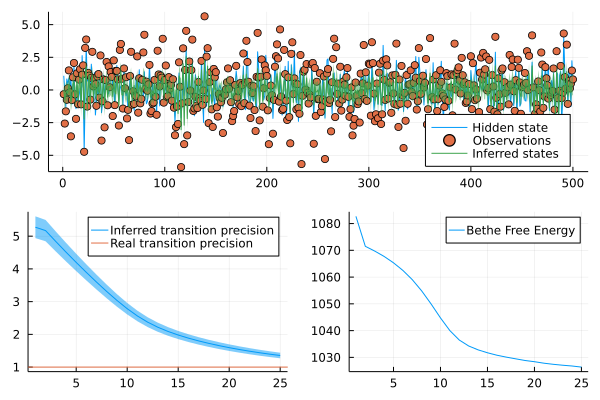

In [11]:
p1 = plot(first.(states), label="Hidden state")
p1 = scatter!(p1, observations, label="Observations")
p1 = plot!(p1, first.(mean.(x)), ribbon = first.(std.(x)), label="Inferred states", legend = :bottomright)

p2 = plot(mean.(γ), ribbon = std.(γ), label = "Inferred transition precision", legend = :topright)
p2 = plot!([ real_γ ], seriestype = :hline, label = "Real transition precision")

p3 = plot(fe, label = "Bethe Free Energy")

plot(p1, p2, p3, layout = @layout([ a; b c ]))

Let's also plot a subrange of our results:

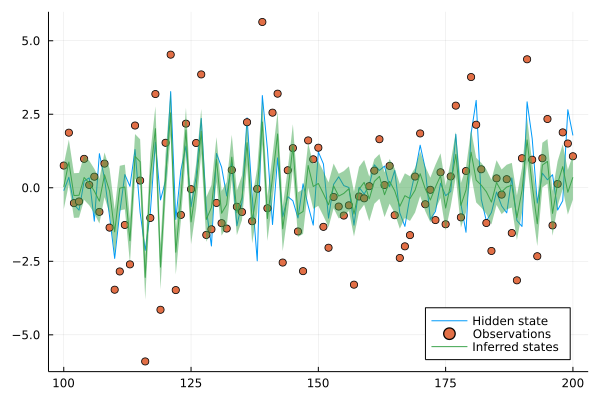

In [12]:
subrange = div(n,5):(div(n, 5) + div(n, 5))

plot(subrange, first.(states)[subrange], label="Hidden state")
scatter!(subrange, observations[subrange], label="Observations")
plot!(subrange, first.(mean.(x))[subrange], ribbon = sqrt.(first.(var.(x)))[subrange], label="Inferred states", legend = :bottomright)

It is also interesting to see where our AR coefficients converge to:

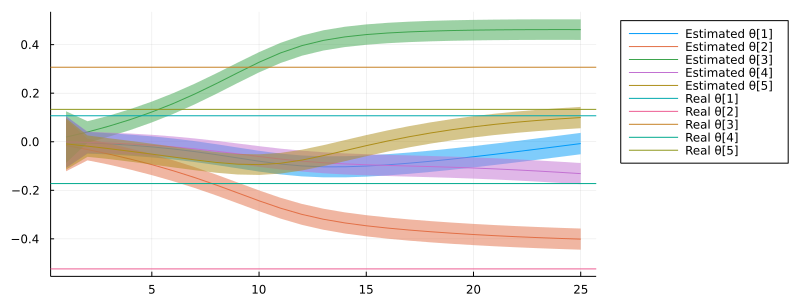

In [13]:
let
    pθ = plot()

    θms = mean.(θ)
    θvs = var.(θ)
    
    l = length(θms)

    edim(e) = (a) -> map(r -> r[e], a)

    for i in 1:length(first(θms))
        pθ = plot!(pθ, θms |> edim(i), ribbon = θvs |> edim(i) .|> sqrt, label = "Estimated θ[$i]")
    end
    
    for i in 1:length(real_θ)
        pθ = plot!(pθ, [ real_θ[i] ], seriestype = :hline, label = "Real θ[$i]")
    end
    
    plot(pθ, legend = :outertopright, size = (800, 300))
end

In [14]:
println("$(length(real_θ))-order AR inference Bethe Free Energy: ", last(fe))

5-order AR inference Bethe Free Energy: 1026.377974436586


We can also run a 1-order AR inference on 5-order AR data:

In [15]:
uorder  = 1
uartype = Univariate
uc      = ReactiveMP.ar_unit(uartype, uorder)
uconstraints = ar_constraints()
umeta        = ar_meta(uartype, uorder, ARsafe())

uoptions = (limit_stack_depth = 100, )

umodel         = lar_model(uartype, length(observations), uorder, uc, real_τ)
udata          = (y = observations, )
uinitmarginals = (γ = GammaShapeRate(1.0, 1.0), θ = NormalMeanPrecision(0.0, 1.0))
ureturnvars    = (x = KeepLast(), γ = KeepEach(), θ = KeepEach())

uresult = inference(
    model = umodel, 
    data  = udata,
    meta  = umeta,
    constraints   = uconstraints,
    initmarginals = uinitmarginals,
    returnvars    = ureturnvars,
    free_energy   = true,
    iterations    = 15, 
    showprogress  = false
);

We can see that, according to final Bethe Free Energy value, in this example 5-order AR process can describe data better than 1-order AR.

We may be also interested in benchmarking our algorithm:

In [16]:
println("Benchmark for n = $n and AR $(uorder) order inference");

@benchmark inference(
    model = $umodel, 
    constraints = $uconstraints,
    meta = $umeta, 
    data = $udata, 
    initmarginals = $uinitmarginals, 
    free_energy = true, 
    iterations = 15, 
    showprogress = false
)

Benchmark for n = 500 and AR 1 order inference


BenchmarkTools.Trial: 22 samples with 1 evaluation.
 Range (min … max):  210.227 ms … 275.312 ms  ┊ GC (min … max):  0.00% … 19.76%
 Time  (median):     243.176 ms               ┊ GC (median):    13.27%
 Time  (mean ± σ):   238.203 ms ±  19.141 ms  ┊ GC (mean ± σ):  10.54% ±  7.37%

  ▁▁█ █      ▁           ▁   ▁▁▁  █▁█ █   ▁▁                ▁ ▁  
  ███▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁███▁▁███▁█▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█ ▁
  210 ms           Histogram: frequency by time          275 ms <

 Memory estimate: 85.34 MiB, allocs estimate: 1702192.

In [17]:
println("Benchmark for n = $n and AR $(morder) order inference");

@benchmark inference(
    model = $mmodel, 
    constraints = $mconstraints, 
    meta = $mmeta, 
    data = $mdata, 
    initmarginals = $minitmarginals, 
    free_energy = true, 
    iterations = 15, 
    showprogress = false
)

Benchmark for n = 500 and AR 5 order inference


BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  510.972 ms … 576.614 ms  ┊ GC (min … max): 11.83% … 18.57%
 Time  (median):     546.571 ms               ┊ GC (median):    14.60%
 Time  (mean ± σ):   545.444 ms ±  17.131 ms  ┊ GC (mean ± σ):  14.98% ±  1.93%

  █                █          █ █ ███     █ █                 █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁█▁███▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  511 ms           Histogram: frequency by time          577 ms <

 Memory estimate: 290.73 MiB, allocs estimate: 2455218.